# Test (classification supervised learning)

In [1]:
%matplotlib inline

In [2]:
%run setup_environment.py
%run custom_tools.py
%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [3]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False, nrows = 10000)
impact.shape

(10000, 63)

## Feature processsing

### `is_somatic`

In [4]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,9649,96.5%
UNLIKELY,281,2.8%
MANUAL_OK,70,0.7%


In [5]:
impact['is_somatic'] = impact.confidence_class.isin(["AUTO_OK", "MANUAL_OK"])
get_table(impact.is_somatic)

,count_,freq_
True,9719,97.2%
False,281,2.8%


### `is_driver`

In [6]:
get_table(impact.oncogenic)

,count_,freq_
Unknown,6350,63.5%
Likely Oncogenic,2689,26.9%
Oncogenic,764,7.6%
Predicted Oncogenic,162,1.6%
Likely Neutral,19,0.2%
Inconclusive,16,0.2%


In [7]:
impact['is_driver'] = impact.oncogenic.isin(['Likely Oncogenic', 'Oncogenic', 'Predicted Oncogenic'])
get_table(impact.is_driver)

,count_,freq_
False,6385,63.8%
True,3615,36.2%


## Setup the train/test sets

In [8]:
label_feature_name = 'is_driver'
feature_names = ['t_vaf', 'gene_type', 'VEP_Consequence', 'VEP_SIFT_score', 'is_driver']
categorical_features_names = ['gene_type', 'VEP_Consequence']

In [9]:
impact_sel = impact[feature_names].dropna()

In [10]:
impact_sel = pd.get_dummies(impact_sel, columns = categorical_features_names, sparse = True)

In [11]:
# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact_sel))
impact_sel = impact_sel.iloc[permutation]

X = impact_sel.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_sel[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(7267, 8)
(7267,)


In [12]:
get_table(y)

,count_,freq_
False,5729,78.8%
True,1538,21.2%


In [13]:
from sklearn.model_selection import cross_val_score

n_folds = 5

## Random model

Accuracy: 0.67 ± 0.02 | AUC: 0.51 ± 0.02


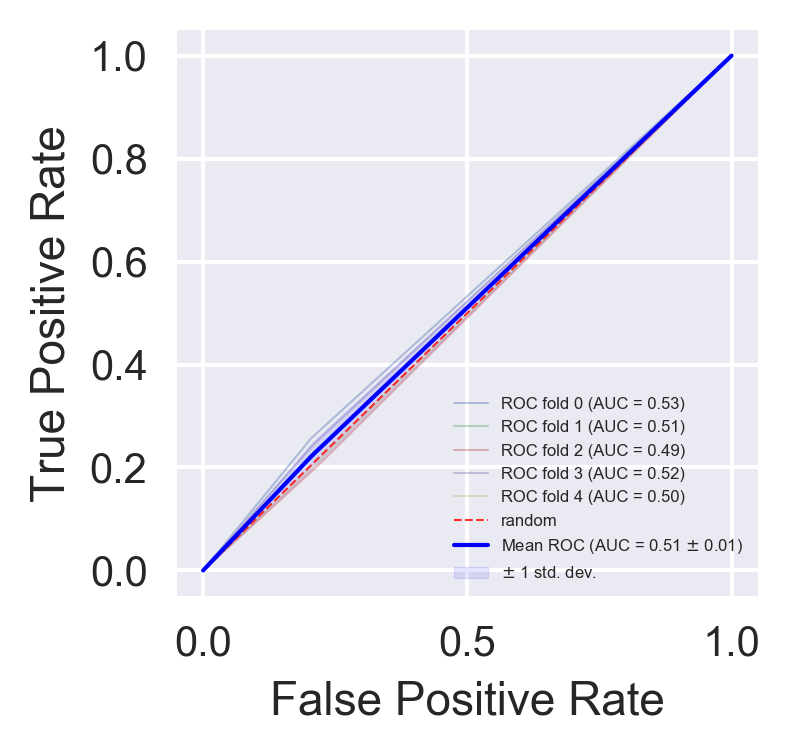

In [16]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(random_state = 1)

accuracy_scores = cross_val_score(model, X, y, cv = n_folds)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std() * 2, auc_scores.mean(), auc_scores.std() * 2))
plot_cross_validation_ROC_curves(model, X, y, 5);

## Logistic Regression

Accuracy: 0.80 ± 0.02 | AUC: 0.79 ± 0.03


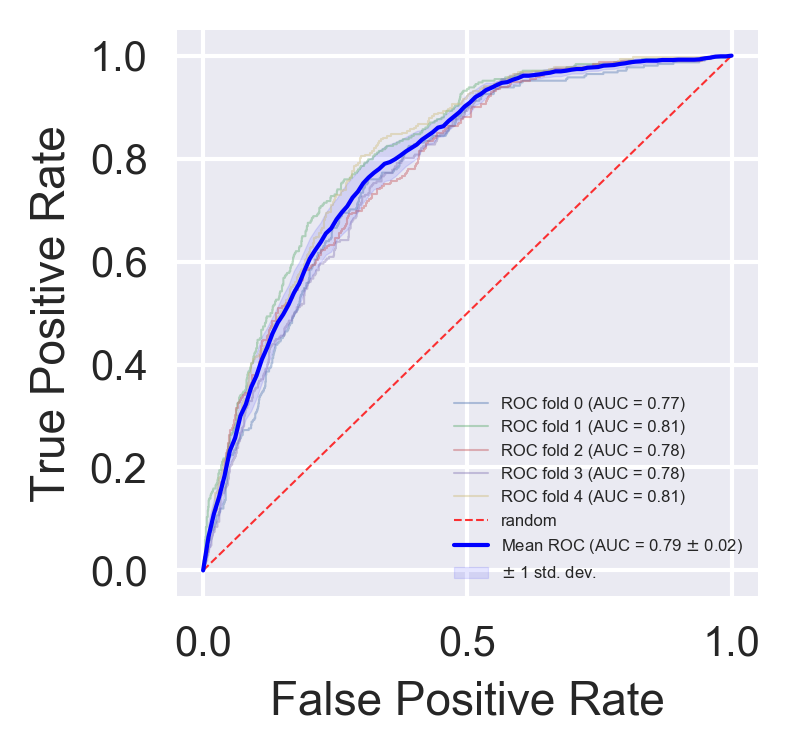

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state = 1)

accuracy_scores = cross_val_score(model, X, y, cv = n_folds)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std() * 2, auc_scores.mean(), auc_scores.std() * 2))
plot_cross_validation_ROC_curves(model, X, y, 5);

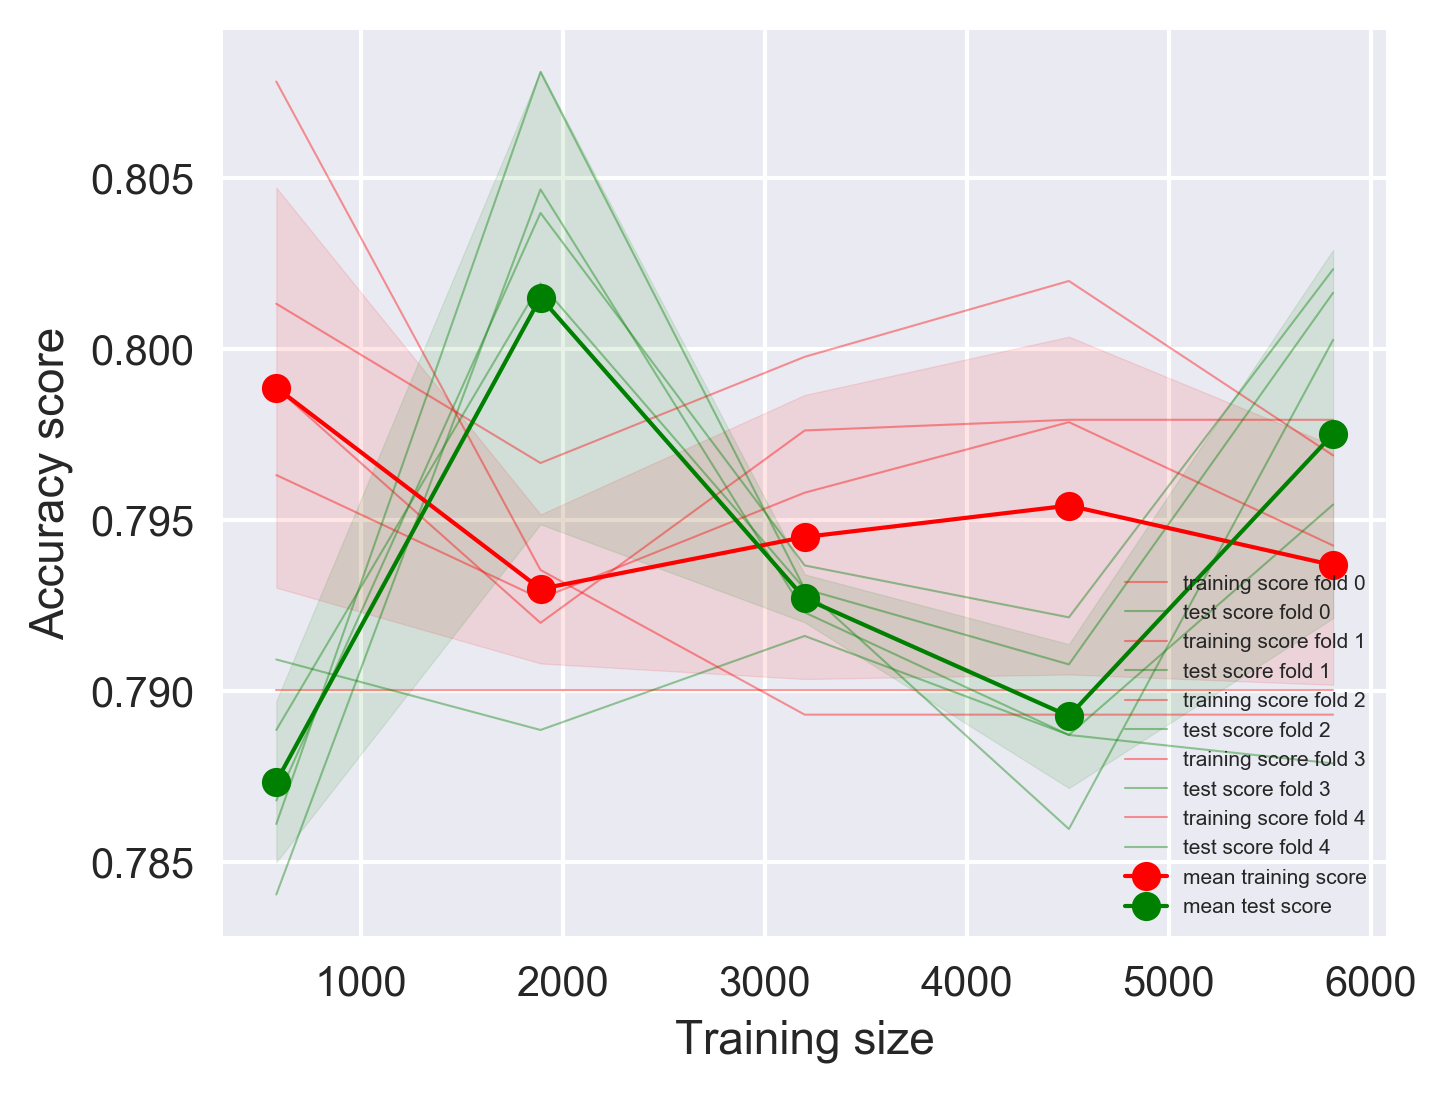

In [26]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

## K Nearest Neighbors

Accuracy: 0.79 ± 0.01 | AUC: 0.76 ± 0.02


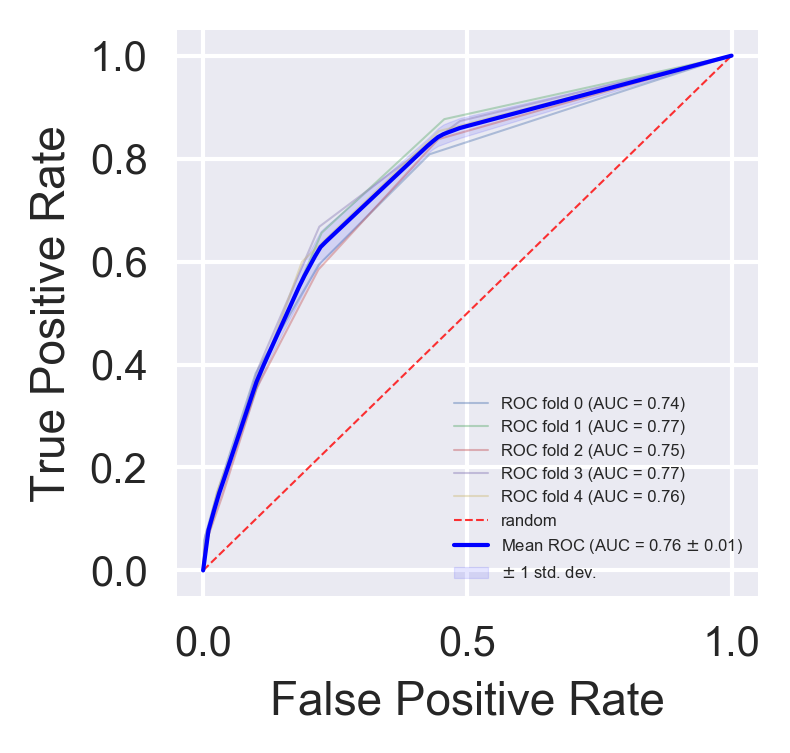

In [32]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors = 5)

accuracy_scores = cross_val_score(model, X, y, cv = n_folds)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std() * 2, auc_scores.mean(), auc_scores.std() * 2))
plot1 = plot_cross_validation_ROC_curves(model, X, y, 5);

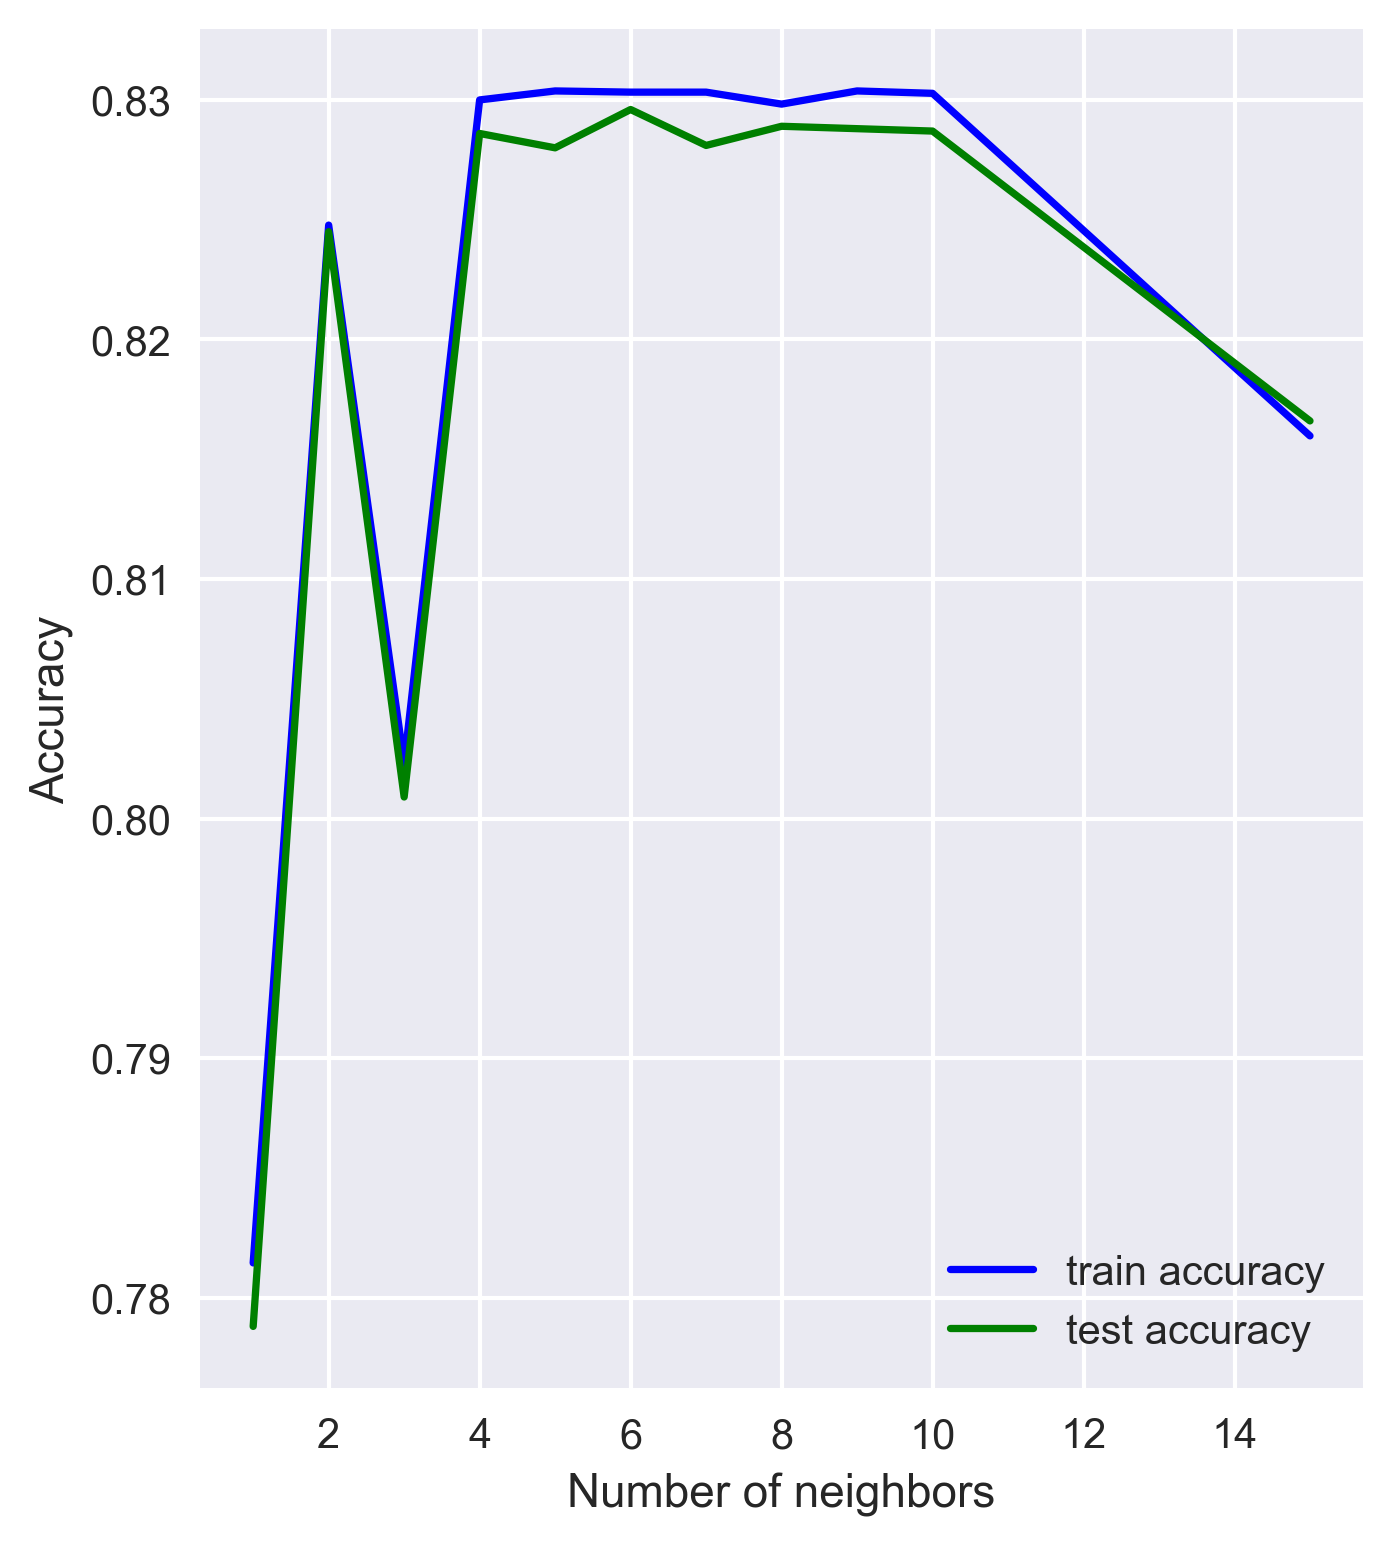

In [110]:
from sklearn.model_selection import validation_curve
n_neighbors = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15]
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X, y, param_name = "n_neighbors", param_range = n_neighbors, cv = n_folds)

plt.figure(figsize = (5, 6))
plt.plot(n_neighbors, train_scores.mean(axis = 1), 'b', label = "train accuracy")
plt.plot(n_neighbors, test_scores.mean(axis = 1), 'g', label = "test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Number of neighbors')
#plt.xlim([50, 0])
plt.legend(loc = "best");

## Gaussian Naive Bayes

Accuracy: 0.33 ± 0.10 | AUC: 0.79 ± 0.03


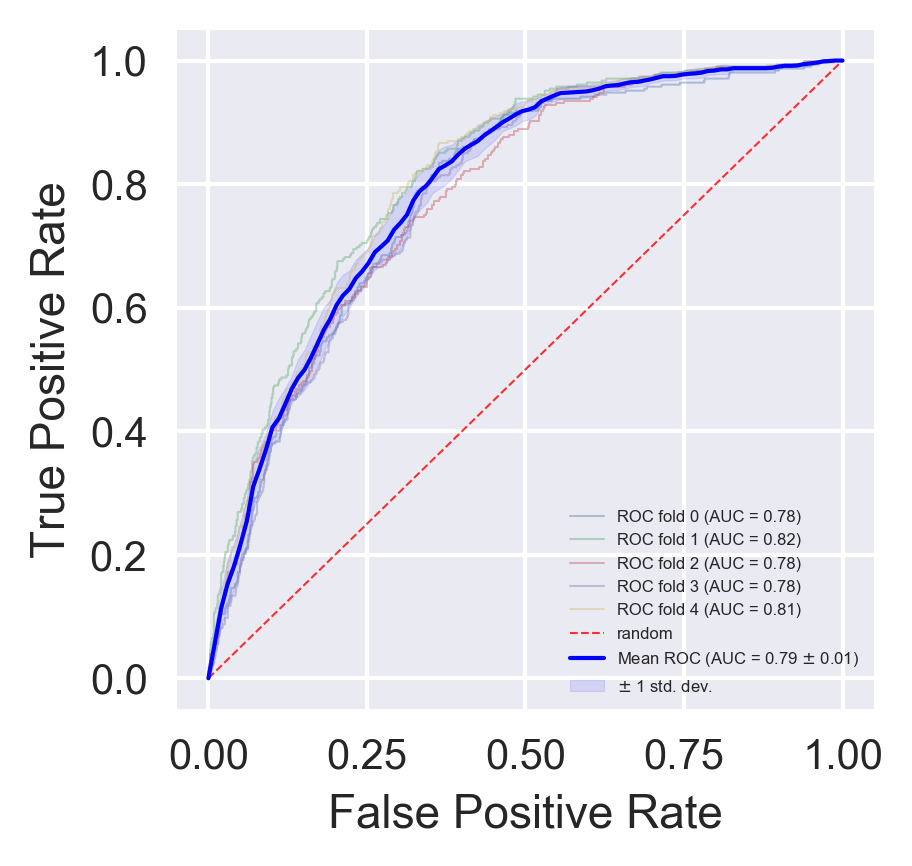

In [28]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

accuracy_scores = cross_val_score(model, X, y, cv = n_folds)
auc_scores = cross_val_score(model, X, y, cv = n_folds, scoring = "roc_auc")
print("Accuracy: %0.2f ± %0.2f | AUC: %0.2f ± %0.2f" % (accuracy_scores.mean(), accuracy_scores.std() * 2, auc_scores.mean(), auc_scores.std() * 2))
plot_cross_validation_ROC_curves(model, X, y, 5)

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel = 'linear', C = 1E10)

scores = cross_val_score(model, X, y, cv = n_folds)
print("Accuracy: %0.2f ± %0.2f" % (scores.mean(), scores.std() * 2))

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

for gamma in [.01, .05, 1]:
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (recall)")
    svm = SVC(gamma=gamma).fit(X_train, y_train)
    decision_function = svm.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, decision_function)
    acc = svm.score(X_test, y_test)
    auc = roc_auc_score(y_test, svm.decision_function(X_test))
    plt.plot(fpr, tpr, label="acc:%.2f auc:%.2f" % (acc, auc), linewidth=3)
plt.legend(loc="best");

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

model = RandomForestClassifier(n_estimators = 200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

model_grid = GridSearchCV(model, parameters, n_jobs = -1)
scores = cross_val_score(model_grid, X, y, cv = n_folds)
print("Accuracy: %0.2f ± %0.2f" % (scores.mean(), scores.std() * 2))